In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import cv2
import numpy as np
from skimage import transform as trans
import matplotlib.pyplot as plt

In [2]:
class FacePreprocessor:
    def __init__(self,image_size='112,112',margin=44):
        self.image_size = [int(x) for x in image_size.split(',')]
        if len(self.image_size) == 1:
            self.image_size = [self.image_size[0],self.image_size[0]]
        self.margin = margin
        assert len(self.image_size) == 2
        assert self.image_size[0] == 112 and (self.image_size[1] == 112 or self.image_size[1] == 96)
    def read_image(self,img_path,mode='rgb',layout='HWC'):
        if mode == 'gray': # gray -> gray
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if mode == 'rgb':
                img = img[..., ::-1]
            if layout == 'CHW':
                img = np.transpose(img,(2,0,1))
        return img
    def preprocess(self, img, bbox=None, landmark=None):
        if isinstance(img, str):
            img = self.read_image(img)

        M = None
        if landmark is not None:
            assert len(self.image_size) == 2
            src = np.array([
                [30.2946, 51.6963],
                [65.5318, 51.5014],
                [48.0252, 71.7366],
                [33.5493, 92.3655],
                [62.7299, 92.2041]], dtype=np.float32)

            if self.image_size[1] == 112:
                src[:, 0] += 8.0
            dst = landmark.astype(np.float32)

            tform = trans.SimilarityTransform()
            tform.estimate(dst, src)
            M = tform.params[0:2, :]

        if M is None:
            return self._center_crop(img, bbox)
        else:
            return self._warp_image(img, M)

    def _center_crop(self, img, bbox):
        if bbox is None:
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1] * 0.0625)
            det[1] = int(img.shape[0] * 0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
            det = bbox

        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0] - self.margin // 2, 0)
        bb[1] = np.maximum(det[1] - self.margin // 2, 0)
        bb[2] = np.minimum(det[2] + self.margin // 2, img.shape[1])
        bb[3] = np.minimum(det[3] + self.margin // 2, img.shape[0])

        ret = img[bb[1]:bb[3], bb[0]:bb[2], :]
        if len(self.image_size) > 0:
            ret = cv2.resize(ret, (self.image_size[1], self.image_size[0]))
        return ret

    def _warp_image(self, img, M):
        assert len(self.image_size) == 2
        warped = cv2.warpAffine(img, M, (self.image_size[1], self.image_size[0]), borderValue=0.0)
        return warped


In [8]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.0 MB/s eta 0:00:00


In [9]:
detector = MTCNN()

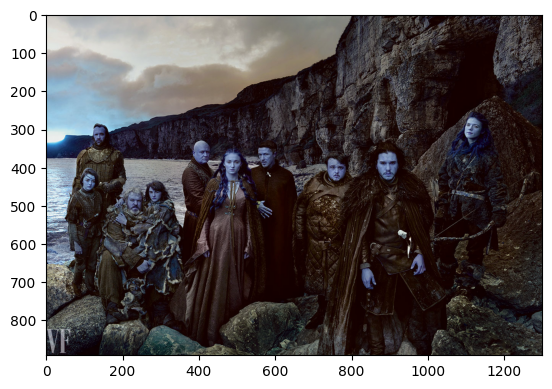

In [14]:
img = cv2.imread("/content/drive/MyDrive/coconut/small_datasets/test/001.jpg")
plt.imshow(img)

In [15]:
bboxes = detector.detect_faces(img)
bboxes

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[{'box': [1099, 271, 42, 53],
  'confidence': 0.9999998211860657,
  'keypoints': {'left_eye': (1107, 290),
   'right_eye': (1126, 294),
   'nose': (1112, 300),
   'mouth_left': (1105, 311),
   'mouth_right': (1120, 313)}},
 {'box': [742, 383, 43, 53],
  'confidence': 0.999993622303009,
  'keypoints': {'left_eye': (752, 402),
   'right_eye': (772, 403),
   'nose': (761, 413),
   'mouth_left': (753, 425),
   'mouth_right': (768, 425)}},
 {'box': [98, 422, 29, 38],
  'confidence': 0.9999480843544006,
  'keypoints': {'left_eye': (109, 436),
   'right_eye': (123, 438),
   'nose': (116, 445),
   'mouth_left': (108, 451),
   'mouth_right': (119, 453)}},
 {'box': [393, 345, 36, 44],
  'confidence': 0.9999112486839294,
  'keypoints': {'left_eye': (409, 361),
   'right_eye': (425, 362),
   'nose': (421, 370),
   'mouth_left': (410, 379),
   'mouth_right': (424, 379)}},
 {'box': [868, 364, 53, 67],
  'confidence': 0.9999012351036072,
  'keypoints': {'left_eye': (883, 390),
   'right_eye': (908, 3

In [24]:
! pip install onnxruntime
import onnxruntime as ort
class FaceModel:
    def __init__(self, embedding_model_path):
        self.session = ort.InferenceSession(embedding_model_path)
    def preprocess_image(self,img_path):
        img = cv2.imread(img_path)
        # img = face_preprocess.preprocess(img,bbox,points,image_size='122,122')
        img = cv2.resize(img,
                    (112,112))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = np.transpose(img,(2,0,1)).astype(np.float32)
        img = img/255.0
        img = np.expand_dims(img, axis=0)
        return img
    def get_embedding(self,img):
        inputs = self.session.get_inputs()
        outputs = self.session.run(None,
                                   {inputs[0].name:img})
        embedding = outputs[0]
        return embedding[0]
embedding_model_path = "/content/drive/MyDrive/coconut/buffalo_l/w600k_r50.onnx"
face_model = FaceModel(embedding_model_path)

In [29]:
import pickle

In [30]:
embeddings = "/content/drive/MyDrive/coconut/outputs/embeddings_small_datasets.pickle"
le = "/content/drive/MyDrive/coconut/outputs/le.pickle"
with open(embeddings,"rb") as f:
    data = pickle.load(f)
# data
with open(le,"rb") as f:
    le = pickle.load(f)

In [34]:
from keras.models import load_model
mymodel = "/content/drive/MyDrive/coconut/outputs/my_model.h5"
# Load the classifier model
model = load_model(mymodel)

{'left_eye': (1107, 290), 'right_eye': (1126, 294), 'nose': (1112, 300), 'mouth_left': (1105, 311), 'mouth_right': (1120, 313)}
[[1107  290]
 [1126  294]
 [1112  300]
 [1105  311]
 [1120  313]]


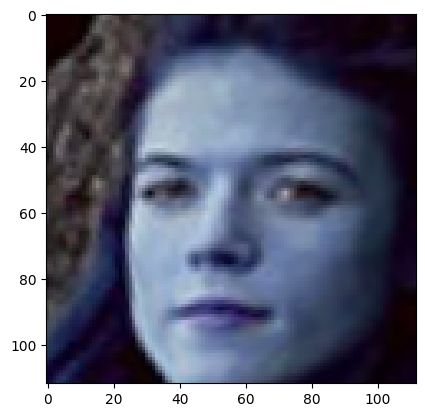

In [38]:
preprocessor = FacePreprocessor(image_size='112,112',margin=44)
if len(bboxes) != 0:
    for bboxe in bboxes:
        bbox = bboxe['box']
        bbox = np.array([bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]])      # Frame ของหน้า
        landmarks = bboxe['keypoints']
        print(landmarks)
        landmarks = np.array([                                                  # Extract landmark keypoint
            landmarks["left_eye"][0],
            landmarks["right_eye"][0],
            landmarks["nose"][0],
            landmarks["mouth_left"][0],
            landmarks["mouth_right"][0],
            landmarks["left_eye"][1],
            landmarks["right_eye"][1],
            landmarks["nose"][1],
            landmarks["mouth_left"][1],
            landmarks["mouth_right"][1]
        ])
        # print(landmarks)
        landmarks = landmarks.reshape((2,5)).T
        print(landmarks)
        nimg = preprocessor.preprocess(img,bbox,landmarks)
        plt.imshow(nimg)

        prep_img = face_model.preprocess_image(nimg)
        # print(prep_img)
        # Get the face embedding vector
        # embedding = face_model.get_embedding(prep_img)
        break

In [43]:
embedding = face_model.get_embedding(prep_img).reshape(1,-1)

In [41]:
model

<Sequential name=sequential_5, built=True>

In [44]:
preds = model.predict(embedding)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [45]:
preds

array([[9.9969018e-01, 3.0968967e-04, 1.1600605e-07]], dtype=float32)

In [47]:
preds = preds.flatten()
preds

array([9.9969018e-01, 3.0968967e-04, 1.1600605e-07], dtype=float32)

In [50]:
j = np.argmax(preds)
proba = preds[j]
proba

0.9996902

In [52]:
embeddings = "/content/drive/MyDrive/coconut/outputs/embeddings_small_datasets.pickle"
le = "/content/drive/MyDrive/coconut/outputs/le.pickle"
with open(embeddings,"rb") as f:
    data = pickle.load(f)
# data
with open(le,"rb") as f:
    le = pickle.load(f)
embeddings = np.array(data['embeddings'])
labels = le.fit_transform(data['names'])

In [54]:
match_class_idx = (labels == j)
match_class_idx

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [56]:
match_class_idx = np.where(match_class_idx)[0]
match_class_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [66]:
comparing_num = 5
cosine_threshold = 0.8
proba_threshold = 0.85
text = 'unknow'

In [60]:
selected_idx = np.random.choice(match_class_idx, comparing_num)
compare_embeddings = embeddings[selected_idx]
compare_embeddings

array([[-0.3502831 ,  1.7229797 ,  2.2767267 , ...,  0.1855112 ,
         0.4216046 , -0.14922483],
       [-0.21267858,  0.19367196,  1.0116677 , ..., -0.8113111 ,
        -0.8691441 ,  0.96603435],
       [-0.691149  ,  0.34555256,  0.9015133 , ...,  0.00797787,
        -0.21807629, -0.9634405 ],
       [-0.51599073, -0.8154189 , -0.12267026, ..., -1.9240826 ,
        -1.0720288 , -0.6665628 ],
       [ 0.473374  , -0.87317556,  1.4550569 , ..., -1.2340864 ,
        -0.13175812,  0.58360213]], dtype=float32)

In [62]:
def findCosineDistance(vector1, vector2):
    vec1 = vector1.flatten()
    vec2 = vector2.flatten()

    a = np.dot(vec1.T,vec2)
    b = np.dot(vec1.T,vec1)
    c = np.dot(vec2.T,vec2)

    return 1 - (a/(np.sqrt(b)*np.sqrt(c)))
def CosineSimilarity(test_vec, source_vecs):
    cos_dist = 0
    for source_vec in source_vecs:
        cos_dist += findCosineDistance(test_vec, source_vec)
    return cos_dist/len(source_vecs)

In [67]:
# Calculate cosine similarity
cos_similarity = CosineSimilarity(embedding, compare_embeddings)
if cos_similarity < cosine_threshold and proba > proba_threshold:
    name = le.classes_[j]
    text = "{}".format(name)
    print("Recognized: {} <{:.2f}>".format(name, proba*100))

y = bbox[1] - 10 if bbox[1] - 10 > 10 else bbox[1] + 10
cv2.putText(img, text, (bbox[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)

array([[[209, 208, 198],
        [208, 207, 197],
        [208, 206, 198],
        ...,
        [ 25,   4,   3],
        [ 23,   2,   1],
        [ 21,   0,   0]],

       [[209, 208, 198],
        [208, 207, 197],
        [208, 206, 198],
        ...,
        [ 23,   2,   1],
        [ 22,   1,   0],
        [ 22,   1,   0]],

       [[209, 208, 198],
        [209, 208, 198],
        [209, 207, 199],
        ...,
        [ 21,   0,   0],
        [ 22,   1,   0],
        [ 22,   1,   0]],

       ...,

       [[ 26,  24,  24],
        [ 39,  34,  35],
        [ 34,  27,  30],
        ...,
        [ 65,  70,  68],
        [ 54,  53,  55],
        [ 28,  24,  29]],

       [[ 23,  23,  29],
        [ 57,  55,  61],
        [ 41,  37,  43],
        ...,
        [ 87,  96,  93],
        [ 53,  57,  58],
        [ 42,  43,  47]],

       [[  0,   0,   9],
        [ 44,  43,  53],
        [ 34,  31,  40],
        ...,
        [ 89, 100,  97],
        [ 53,  58,  59],
        [ 26,  29,  33]]

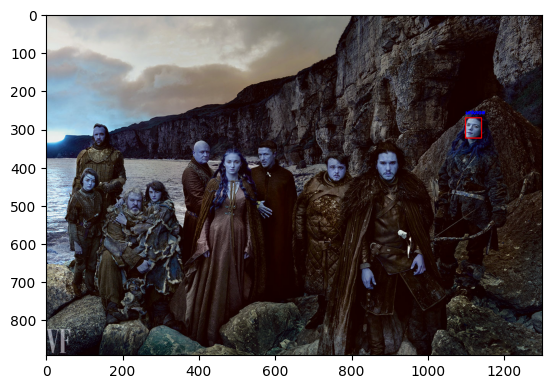

In [72]:
plt.imshow(img)

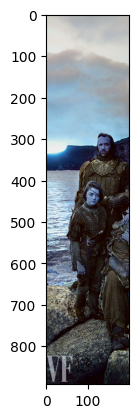

In [75]:
plt.imshow(img[:,:200])